# Predicting House Prices - Ames DataSet (Kaggle Competition)

This project will use the Ames dataset to train various models with the intention of arriving at the lowest possible value for the error metric chosen by Kaggle for this competition: the mean squared logarithmic error.

First, the data will be cleaned and features that are not useful will be removed. For the beginning, thse features will be chosen intuitively. Features that seemingly run the risk of high collinearity will also be removede at the offset. Once it is established that there is room for imrpovemenmt, more technical approaches will be taken in choosing features in order to optimize the model.

In the same sweeping move, features to be included in training will be respectively engineered to garner useful predicitve outputs. This will involve creating dummies for all categorical columns. Again, this is essentially a pre-process to test the water so to speak. Further feature engineering will be done once a baseline of accuracy has been established and can be used as a benchmark for further improvement.

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')


cols_to_drop = ['LotFrontage', 'Street', 'Alley', 'LandContour',
               'YearRemodAdd', 'YearBuilt', 'RoofStyle', 'MasVnrArea',
               'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
               'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'FullBath',
               'BsmtHalfBath', 'HalfBath', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageType',
               'GarageCars', 'GarageQual', 'EnclosedPorch', 'OpenPorchSF', 'ScreenPorch', 'PoolArea',
               'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', '3SsnPorch']

cols_for_dummies = ['MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', 'OverallQual', 'OverallCond', 'Utilities',
                    'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
                    'BldgType', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                    'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'Heating', 
                    'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
                    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'house_age']


## Exploring the data and the distribution of values

We will now make an attempt to explore the layout of the data. We will do this to determine if there is a linear relationship between the 'features' and the target variable. If there is we know that linear regression is, tentatively, a good model to begin with. At the same time we will have to determine if the errors follow a normal distribution - another prerequisite for successfull linear regression. We also take a look at the correlation between some columns and the target column: 'SalePrice'. Using this we could exclude some columns that won't be useful for our model.

We will also look at factors that intuitively would be highly relevant to the SalePrice, and in doing so identify outliers that we can remove from the data in order to achieve more accuracte predictions.

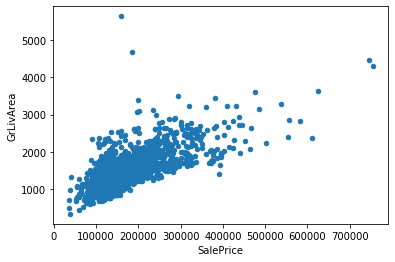

In [2]:
%matplotlib inline

## Looking for Outliers

train.plot.scatter('SalePrice', 'GrLivArea')

In [3]:
outliers = train[train['GrLivArea'] > 4500]

outliers



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [4]:
train = train.drop([523,1298])

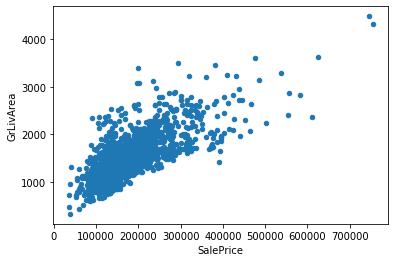

In [5]:
## Demonstrating that outliers have been dealt with

train.plot.scatter('SalePrice', 'GrLivArea')

In [6]:
correlations = train.corr().abs()

correlations['SalePrice'].sort_values(ascending = False).head(50)

SalePrice        1.000000
OverallQual      0.795774
GrLivArea        0.734968
TotalBsmtSF      0.651153
GarageCars       0.641047
1stFlrSF         0.631530
GarageArea       0.629217
FullBath         0.562165
TotRmsAbvGrd     0.537769
YearBuilt        0.523608
YearRemodAdd     0.507717
GarageYrBlt      0.487156
MasVnrArea       0.482719
Fireplaces       0.469862
BsmtFinSF1       0.409384
LotFrontage      0.370584
WoodDeckSF       0.324758
OpenPorchSF      0.321142
2ndFlrSF         0.320532
HalfBath         0.284590
LotArea          0.268179
BsmtFullBath     0.228459
BsmtUnfSF        0.214460
BedroomAbvGr     0.168245
KitchenAbvGr     0.135946
EnclosedPorch    0.128646
ScreenPorch      0.111415
PoolArea         0.099490
MSSubClass       0.084276
OverallCond      0.077948
MoSold           0.046124
3SsnPorch        0.044568
YrSold           0.028882
LowQualFinSF     0.025625
Id               0.021673
MiscVal          0.021203
BsmtHalfBath     0.016881
BsmtFinSF2       0.011422
Name: SalePr

## Looking for more outliers

By looking at the correlation of each column to the 'SalePrice' we are able to indetify the most "meaningful" features relative to their potential predictive power. We will now look at the features with over 0.5 as a correlation value. The features within this category that are numeric and continuous will be looked at to find and remoe further outliers. 

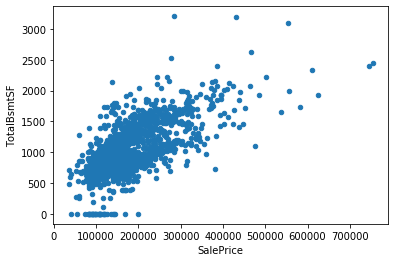

In [7]:
train.plot.scatter('SalePrice', 'TotalBsmtSF')



In [8]:
## the top two points (above 3000 SF and below 500 000 price) look to lie outside the distribution 
## We will remove these two outliers

outliers_2 = train[(train['TotalBsmtSF'] > 3000) & (train['SalePrice'] < 500000)]

outliers_2

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,85.0,10655,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000
496,497,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,430000


In [9]:
train = train.drop([332,496])

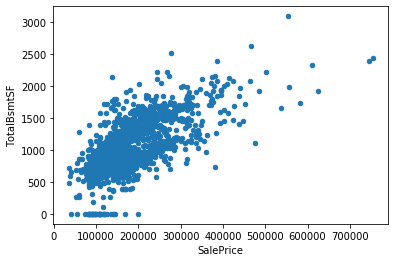

In [10]:
## Demonstrating that outliers have been removed

train.plot.scatter('SalePrice', 'TotalBsmtSF')

## Creating a new binary column for whether a house has a basement (0 = no bsmt, 1 = bsmt)

def has_it_or_not(value):
    if value > 0:
        value = 1
    else:
        value = 0
    return value

train['has_bsmt'] = train['TotalBsmtSF'].apply(has_it_or_not)
holdout['has_bsmt'] = holdout['TotalBsmtSF'].apply(has_it_or_not)

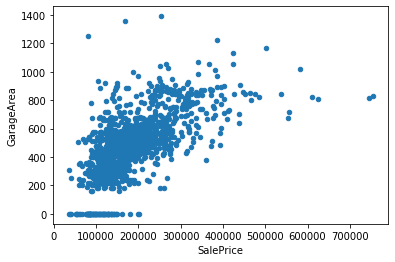

In [11]:
train.plot.scatter('SalePrice', 'GarageArea')

In [12]:
outliers_3 = train[(train['GarageArea'] > 1200) & (train['SalePrice'] < 300000)]

outliers_3
                                                   
                                                

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,has_bsmt
581,582,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,8,2009,New,Partial,253293,1
1061,1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,...,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000,1
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,...,NaN,NaN,NaN,0,3,2007,WD,Normal,168000,1


In [13]:
outliers_4 = train[(train['SalePrice'] > 700000) & (train['GarageArea']> 600)]

outliers_4

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,has_bsmt
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,1,2007,WD,Normal,755000,1
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000,1


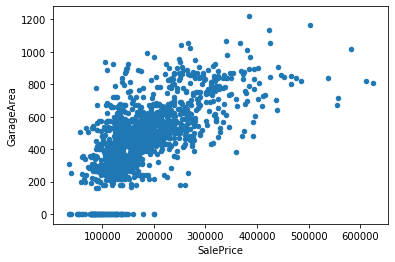

In [14]:
train = train.drop([581,1061,1190,691,1182])

train.plot.scatter('SalePrice', 'GarageArea')

train['has_garage'] = train['GarageArea'].apply(has_it_or_not)
holdout['has_garage'] = holdout['GarageArea'].apply(has_it_or_not)

## Distribution

As is evident, right now the distribution is skewed to the left. In order to solve this we will use a log function to even out the distribution.

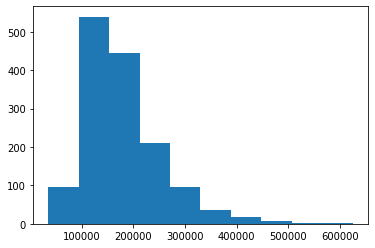

In [15]:
import matplotlib.pyplot as plt

## Illustrating that the Target Variable is unbalanced

plt.hist(train['SalePrice'], bins = 10)

plt.show()

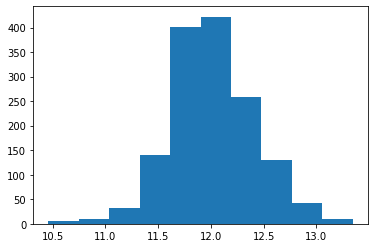

In [16]:
## Normalizing the target variable using log function

train['SalePrice'] = np.log1p(train['SalePrice'])

plt.hist(train['SalePrice'], bins = 10)

plt.show()

In [17]:
## Feature Preparation/engineering

## Creating new columns
train['recent_remod'] = 0
holdout['recent_remod'] = 0

## Making new columns = 1 if remodelled recently (during or after 2001) and 0 otherwise - original col to be dropped
train.loc[train['YearRemodAdd'] >= 1990, ['recent_remod']] = 1
train.loc[train['YearRemodAdd'] < 1990, ['recent_remod']] = 0

holdout.loc[holdout['YearRemodAdd'] >= 1990, ['recent_remod']] = 1
holdout.loc[holdout['YearRemodAdd'] < 1990, ['recent_remod']] = 0

## Summing full bathrooms and half bathrooms - original cols to be dropped
train['t_full_bathrooms'] = train['BsmtFullBath'] + train['FullBath']
train['t_half_bathrooms'] = train['BsmtHalfBath'] + train['HalfBath']

holdout['t_full_bathrooms'] = holdout['BsmtFullBath'] + holdout['FullBath']
holdout['t_half_bathrooms'] = holdout['BsmtHalfBath'] + holdout['HalfBath']

## Summing total porch area in square feet - original cols to be dropped
train['T_porch_area'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['ScreenPorch'] + train['3SsnPorch']
holdout['T_porch_area'] = holdout['OpenPorchSF'] + holdout['EnclosedPorch'] + holdout['ScreenPorch'] + holdout['3SsnPorch']


In [18]:
## Functions for feature preparation/engineering as well as cleaning

def process_year_built(df):
    cut_points = [1870, 1900, 1930, 1960, 1990, 2020]
    label_names = ['ancient', 'extremely_old', 'quite_old', 'recent', 'modern']
    df['house_age'] = pd.cut(df['YearBuilt'], cut_points, labels = label_names)
    return df

def drop_cols(df):
    for col in cols_to_drop:
        df = df.drop(labels = col, axis = 1)
    return df    

def create_dummies(df, col_names):
    dummies = pd.get_dummies(df[col_names], prefix = col_names)
    df = pd.concat([df, dummies], axis = 1)
    return df
    
    
    

In [19]:
train = process_year_built(train)
holdout = process_year_built(holdout)

In [20]:
## Dummies created and subsequently dropped in place of dummies

for col in cols_for_dummies:
    train = create_dummies(train, col)
    train = train.drop(col, axis = 1)
    holdout = create_dummies(holdout, col)
    holdout = holdout.drop(col, axis = 1)

In [21]:
train = drop_cols(train)
holdout = drop_cols(holdout)

In [22]:
## Checking for null values - Training Data

train.loc[:, train.isnull().any()].columns

Index([], dtype='object')

In [23]:
## Checking for null values Target Data

null_columns_holdout = list(holdout.loc[:, holdout.isnull().any()].columns)

null_columns_holdout

['TotalBsmtSF', 'GarageArea', 't_full_bathrooms', 't_half_bathrooms']

In [24]:
holdout.shape

(1459, 223)

In [25]:
## Exploring Null Values

null_col_counts = {}

for col in null_columns_holdout:
    null_val = holdout[col].isnull().sum()
    null_col_counts[col] = null_val

null_col_counts

{'TotalBsmtSF': 1,
 'GarageArea': 1,
 't_full_bathrooms': 2,
 't_half_bathrooms': 2}

In [26]:
cols_to_be_filled = ['TotalBsmtSF', 'GarageArea', 't_full_bathrooms', 't_half_bathrooms']

for col in cols_to_be_filled:
    holdout[col] = holdout[col].fillna(holdout[col].mean())

In [27]:
## Checking to see if null values have been successfully removed

holdout.loc[:, holdout.isnull().any()].columns

Index([], dtype='object')

In [28]:
## Checking null values for train set

null_cols_train = list(train.loc[:, train.isnull().any()].columns)

null_cols_train

[]

In [29]:
null_col_counts_train = {}

for col in null_cols_train:
    null_val = train[col].isnull().sum()
    null_cols_train[col] = null_val
    
null_col_counts_train

{}

In [30]:
from sklearn.preprocessing import minmax_scale

## Scale values so that all values are between 0 and 1 - except 'Id'

cols = train.columns.drop(['Id', 'SalePrice'])
test_cols = holdout.drop('Id', axis = 1).columns
train[cols] = minmax_scale(train[cols])
holdout[test_cols] = minmax_scale(holdout[test_cols])


In [31]:
## Identified that some cols in training set (frpom created dummmies), do not appear in the test set
## Therefore we are identifying these columns and removing them from the cols used for training and predictions

cols_to_drop_holdout = []

for col in cols:
    if col in test_cols:
        pass
    else:
        cols_to_drop_holdout.append(col)

cols_to_drop_holdout

['Utilities_NoSeWa',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'HouseStyle_2.5Fin',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'Heating_Floor',
 'Heating_OthW',
 'Electrical_Mix',
 'PoolQC_Fa',
 'MiscFeature_TenC']

In [32]:
cols = cols.drop(cols_to_drop_holdout)


In [33]:
all_x = train[cols].reset_index(drop = True)
all_y = train['SalePrice'].reset_index(drop = True)



In [34]:
all_y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
5       11.870607
6       12.634606
7       12.206078
8       11.774528
9       11.678448
10      11.771444
11      12.751303
12      11.877576
13      12.540761
14      11.964007
15      11.790565
16      11.911708
17      11.407576
18      11.976666
19      11.842236
20      12.692506
21      11.845110
22      12.345839
23      11.774528
24      11.944714
25      12.454108
26      11.811555
27      12.631344
28      12.242891
29      11.134604
          ...    
1421    12.165985
1422    11.875838
1423    11.074436
1424    12.136192
1425    11.982935
1426    12.066816
1427    11.699413
1428    12.885673
1429    11.916395
1430    12.190964
1431    12.160034
1432    11.913720
1433    12.644331
1434    11.703554
1435    12.098493
1436    11.767575
1437    11.969724
1438    12.388398
1439    11.626263
1440    11.429555
1441    11.820418
1442    12.567555
1443    11.884496
1444    11.344519
1445    12

In [35]:
## Making sure that cols that are not in the test data, are not used for training or predictions
## Therefore we are checking to see if the cols that are not in the test set are in the cols we are using:

no_man = []

for col in all_x.columns:
    if col in cols_to_drop_holdout:
        no_man.append(col)

        
no_man

[]

In [36]:
all_x.shape

(1451, 221)

In [37]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

## Dealing with negative values so that we can use mean_squared_log_error 

def no_negative(prediction):
    if prediction < 0:
        prediction == 0
    return prediction 

## Testing, training and cross_validation pipeline

def train_model(alpha, features, target):
    rr = Ridge(alpha, random_state = 2)
    model = rr.fit(features, target)
    return model
    
def test(model, test_features, test_target):
    msle = []
    pre_predictions = model.predict(test_features)
    predictions = pd.Series(pre_predictions)
    predictions = predictions.apply(no_negative)
    accuracy = mean_squared_log_error(test_target, predictions)
    msle.append(accuracy)
    return msle

def cross_validation(alpha, attributes, target):
    fold_accuracies = []
    kf = KFold(n_splits = 5, shuffle = True, random_state = 2)
    for train_index, test_index in kf.split(attributes):
        train_features, test_features = attributes.loc[train_index], attributes.loc[test_index]
        test_labels, train_labels = target.loc[test_index], target.loc[train_index]
        model = train_model(alpha ,train_features, train_labels)
        accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(accuracy)
    return fold_accuracies



In [38]:
accuracy_by_alpha = []
accuracy_dict = {}
alphas = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6,
          1.8, 2, 2.2, 2.4, 2.6, 2.8, 3, 3.2, 
          3.4, 3.6, 3.8, 4, 4.2, 4.4, 4.6, 4.8, 5,
         5.2, 5.4, 5.6, 5.8, 6, 6.2, 6.4, 6.6, 6.8, 7,
         7.2, 7.4, 7.6, 7.8, 8]

for alpha in alphas:
    alpha_accuracy = cross_validation(alpha, all_x, all_y)
    accuracy_by_alpha.append(np.mean(alpha_accuracy))
    accuracy_dict[alpha] = np.mean(alpha_accuracy)
    
   

The best alpha to train at is 2.2 which achieves an RMSLE value of 9.183663529403954e-05


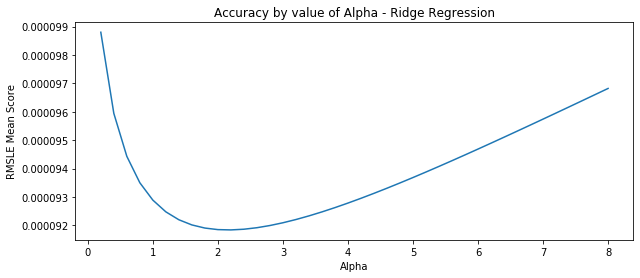

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (10,4))
plt.title('Accuracy by value of Alpha - Ridge Regression')
plt.plot(alphas, accuracy_by_alpha)
plt.xlabel('Alpha')
plt.ylabel('RMSLE Mean Score')

print("The best alpha to train at is" , min(accuracy_dict, key = accuracy_dict.get),
      "which achieves an RMSLE value of" , min(accuracy_dict.values()))

In [40]:
## Submitting final results for first model (ridge regression)

ridge_model = Ridge(5.4, random_state = 2)

mod = ridge_model.fit(all_x, all_y)

predictions_ridge_regression = mod.predict(holdout[cols])

def save_submit(predictions, sub_no):   
    pre_pred = pd.Series(predictions)
    final_predictions = pre_pred.apply(no_negative)
    
    submission_df = {'Id': holdout['Id'], 'SalePrice': final_predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv('submission{}.csv'.format(sub_no), index = False)
 

In [41]:
save_submit(predictions_ridge_regression, 1)

In [42]:
results_dict = {'Attempt': 1, 'Model': 'RidgeRegression', 'RMSLE': 0.16737}

results = pd.DataFrame(results_dict, index = [0])

results


,Attempt,Model,RMSLE
0,1,RidgeRegression,0.16737


In [43]:
## Function for creating table of results - adding results of each model to table

def add_row(attempt, model, rmsle, results):
    temp_dict = {'Attempt': attempt, 'Model': model, 'RMSLE': rmsle}
    temp_df = pd.DataFrame(temp_dict, index = [0])
    results = pd.concat([results, temp_df], axis = 0)
    return results

## Model Tweeking

We will now make an attempt at tweaking this model in order to achieve a lower RMSEL. We will first check the correlation coefficients of the model to determine the strength of certain features in making predictions, we will then use 'Recursive Feature Elimination' to determine which are the best columns to include.


In [44]:
coefficients = mod.coef_

feature_importance = pd.Series(coefficients[0], index = all_x.columns)

feature_importance.sort_values(ascending = False)

feature_importance.value_counts()

0.131184    221
dtype: int64

## Most Important Features

Looking at the top 50 features in terms of their coefficients, i.e how much they affect the SalePrice, the most important areas seem to be:

1. Size of the property
2. Size of the basement
3. The quality of: the kitchen, the bathroom and the bedroom.
4. Size of the deck
5. Was the unit recently remodelled
6. How many cars in the garage
7. Total area of the porch
8. The class of the building
9. The Zoning of the property
10. The shape of the property
11. The configuration of the properyty
12. Overall Quality of the property


In [45]:
selector = RFECV(mod, cv = 10)

selector.fit(all_x, all_y)

optimized_columns = list(all_x.columns[selector.support_])


In [46]:
ridge_model.fit(train[optimized_columns], all_y)

optimized_predictions = ridge_model.predict(holdout[optimized_columns])

save_submit(optimized_predictions, 2)

In [47]:
results = add_row(2, 'RidgeRegression', 0.17065, results)

results

,Attempt,Model,RMSLE
0,1,RidgeRegression,0.16737
0,2,RidgeRegression,0.17065


## Results

It would seem that we have had a worsening of accuracy after using the columns determined through recursive feature elimination. As such we will stick with the original columns we used for the first model.

Now we will go ahead and try an ensemble model: RandomForestRegressor. We will make an attempt first without fiddling too much with the hyper parameters. After we get a baseline score, we will then use GridSearch to determine what the bestr hyperparamter values would be.

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor()

rfr.fit(all_x, all_y)

rfr_predictions = rfr.predict(holdout[cols])

save_submit(rfr_predictions, 3)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
results = add_row(3, 'Random Forest - no hp', 0.2001, results)

results

,Attempt,Model,RMSLE
0,1,RidgeRegression,0.16737
0,2,RidgeRegression,0.17065
0,3,Random Forest - no hp,0.20010


In [50]:
rfr = RandomForestRegressor()

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

hyper_parameters = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap}

rfr_random = RandomizedSearchCV(estimator = rfr, param_distributions = hyper_parameters, 
                                n_iter = 100, cv = 4, verbose = 2, random_state = 2,
                                n_jobs = -1)

rfr_random.fit(all_x, all_y)

rfr_random.best_params_

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 22.5min finished


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

In [51]:
rfr = RandomForestRegressor(n_estimators = 1000,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            max_features =  'sqrt',
                            max_depth = 110,
                            bootstrap = False)

rfr.fit(all_x, all_y)

best_param_predictions = rfr.predict(holdout[cols])

save_submit(best_param_predictions, 4)

results = add_row(4, 'Random Forest - optimal HP', 0.18497, results)

results

,Attempt,Model,RMSLE
0,1,RidgeRegression,0.16737
0,2,RidgeRegression,0.17065
0,3,Random Forest - no hp,0.20010
0,4,Random Forest - optimal HP,0.18497


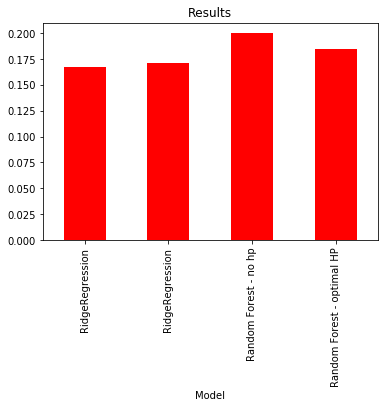

In [57]:
results.plot(kind = 'bar', x = 'Model', y = 'RMSLE', title = 'Results', color = 'red', legend = None)

## Results And Conclusion

These results have not been all together that encouraging. Even after running a randomized search to optmize parameters we are have yet to see an improvement in our error. 

The prupose of this project was primarily to implement code that searched for the best combination of hyperparamters and to  get more familiar with feature evening. This purpose was achieved and now a new attempt will be made with new and unfamiliar data. We may come back to further optoimize this model. 

Hypothetically however, from here, the most viable course of action would appear to be further feature engineering. This could begin with determining if features can be simplified in order to glean more predictive power. Further to that, there are no doubt more advanced methods with which the features can be further engineered. Keep an eye on this project for further updates.

